### Determinação de parâmetros de exoplanetas por ajuste do trânsito pelo algoritmo MCMC

_Por meio da análise da curva de luz de estrelas com trânsitos de exoplanetas e realizando um ajuste dos dados pelo modelo ECLIPSE utilizando o algoritmo MCMC (Markov Chain Monte Carlo) presente neste código, é possível descobrir com maior precisão os parâmetros reais do exoplaneta e sua órbita. O programa foi otimizado para que seu tempo de execução fosse reduzido drasticamente._

In [1]:
#imports
from Adjust.Model import Modelo
from Adjust.Treatment import Tratamento
from Adjust.Adjust import Ajuste, AjusteManchado
from Misc.Verify import converte, calculaLat
from Star.Estrela import Estrela
from Planet.Eclipse import Eclipse
import numpy
import matplotlib.pyplot as plt
import corner

### Entrada Estrela e Eclipse

_A Estrela e o Eclipse serão criados através de classes auxiliares presentes nos arquivos ```eclipse.py``` e ```estrela.py```. A classe Estrela constrói a matriz que representa a estrela, enquanto a classe Eclipse calcula a curva de luz daquela estrela dado parâmetros planetários imputados. Cada planeta também pode conter uma lua em sua órbita, dessa forma, cada eclipse pode possuir uma ou mais luas, através da classe Moon. 
Os parâmetros de criação da estrela e eclipse, juntamente com a(s) lua(s) estão presentes no bloco abaixo._

In [3]:
# -------------- Parâmetros de entrada --------------
# --------------------- Estrela ---------------------
star_name = 'HD 189733A'
cadence = 'short'
raio = 373. #default (pixel)
rsun = 0.805 # raio da estrela em Rsun
intensidadeMaxima = 240 #default
tamanhoMatriz = 856 #default 
u1 = 0.377
u2 = 0.024


# --------------------- Planeta HD 189733 b---------------------
raioPlanJup = 1.138
semiEixoUA = 0.031
anguloInclinacao = 85.51 #em graus
periodo = 2.219  # day
lua = False 
ecc = 0
anom = 0


#etapa de conversão
raioStar, raioPlanetaRstar , semiEixoRaioStar = converte(rsun,raioPlanJup,semiEixoUA)

### Construção da Estrela e do Eclipse
_Após a construção da matriz estrela e do eclipse calculado, temos a resultante da curva de luz representada graficamente abaixo._

0.407747745513916


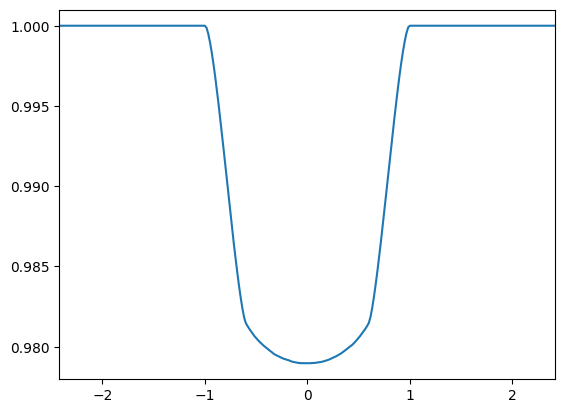

In [4]:
estrela_ = Estrela(raio,raioStar,intensidadeMaxima,u1,u2,tamanhoMatriz)
Nx = estrela_.getNx()
Ny = estrela_.getNy()
raioEstrelaPixel = estrela_.getRaioStar()
estrelaManchada = estrela_.getEstrela()
eclipse = Eclipse(Nx,Ny,raioEstrelaPixel,estrelaManchada)
estrela_.setStarName(star_name)
estrela_.setCadence(cadence)
eclipse.setTempoHoras(1.)



#semiEixoRaioStar,semiEixoUA, raioPlanetaRstar, raioPlanJup ,periodo,anguloInclinacao,lua,ecc,anom
eclipse.criarEclipse(semiEixoRaioStar,semiEixoUA,raioPlanetaRstar,raioPlanJup,periodo,anguloInclinacao,lua,ecc,anom,False)
lc0 = numpy.array(eclipse.getCurvaLuz()) 
ts0 = numpy.array(eclipse.getTempoHoras())

### Criar um modelo através do Eclipse 
_Um modelo será criado através da base de curva de luz construída para que o algorimo seja aplicado_

0.41214489936828613


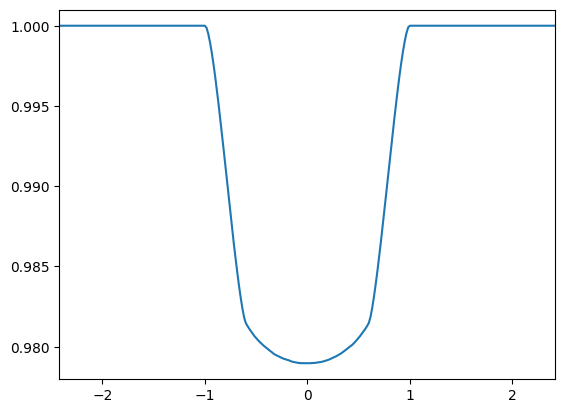

170.0


In [5]:
modelo = Modelo(estrela_, eclipse, "TESS")

ls_model, ts_model = modelo.eclipse_model()

time, flux, flux_err = modelo.rd_data(0, 0)

modelo.setTime(time)
modelo.setFlux(flux)
modelo.setFluxErr(flux_err)

x0, nt = modelo.det_x0(0)

print(nt)

### Tratamendo do modelo 
_Nesta etapa o trânsito será cortado para que seja analisada apenas a etapa onde há variância na curva de luz. A classe ```Modelo``` coleta os dados do telescópio (Kepler ou Tess) obtidos através do ```método de trânsito``` e como esses dados apresentam muitos resíduos, a etapa de tratamento faz-se necessária._

0.4153249263763428


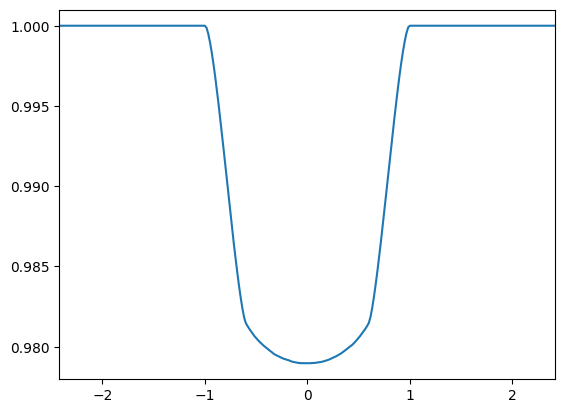

In [6]:
tratamento = Tratamento(modelo)

dur, tim, lcurve, f_err = tratamento.cut_transit_single()

t_p = tim[100]
s_lc = lcurve[100]

bb = numpy.where((t_p >= min(ts0)) & (t_p <= max(ts0)))
bb = numpy.where((ts0 >= -5.) & (ts0 <= 5.))
dd = numpy.where((t_p >= -5.) & (t_p <= 5.))

### Curvas de luz resultantes 
_Abaixo, temos representadas a curva de luz inicial com a curva de luz obtida através dos dados inputados pelo telescópio (```LightKurve```) após o tratamento. É utilizada a curva de luz inicial para a comparação da curva de luz obtida através do telescópio._

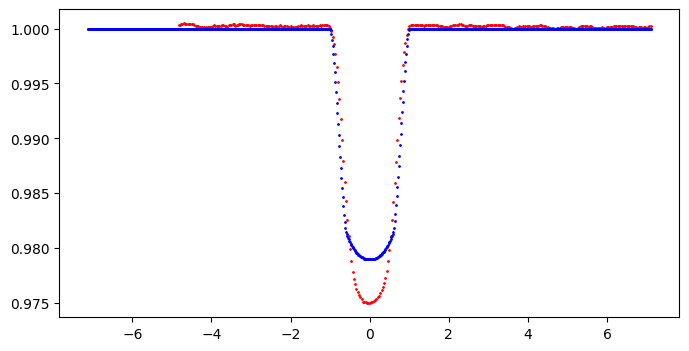

In [10]:
# COM ESCOLHA DE TRÂNSITO
selectedTransit = 2 #transito selecionado
time_phased, smoothed_LC = tratamento.select_transit_smooth(selectedTransit)

plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(time_phased, smoothed_LC, "r.", ms = 2)
ax.plot(ts_model, ls_model, "b.", ms = 2)

# MCMC
_Ajustes realizados para a aplicação do algoritmo MCMC. As variáveis ```nwalkers```, ```niter``` e ```burnin``` podem ser alteradas conforme o pesquisador achar necessário para a aplicação do algoritmo_

In [7]:
nwalkers = 50
niter = 50
burnin = 30

ajuste = Ajuste(tratamento, time_phased, smoothed_LC, nwalkers, niter, burnin)

time = time_phased
flux = smoothed_LC

### Chamada do algoritmo MCMC

In [8]:
sampler, pos, prob, state = ajuste.main()

Running burn-in...


100%|██████████| 30/30 [18:00<00:00, 36.02s/it]


Running production...


100%|██████████| 50/50 [28:45<00:00, 34.51s/it]


### Valores obtidos pós aplicação do algoritmo

In [9]:
# os valores aqui resultados podem ser utilizados no mcmc manchado
samples = sampler.flatchain
samples[numpy.argmax(sampler.flatlnprobability)]

array([3.72241883e-01, 5.79127854e-01, 1.74614676e-02, 8.78364102e+01,
       1.23514457e+00])

### Conclusão 
_Abaixo teremos a curva de luz obtida pelo satélite comparada com a curva de luz tratada através do algoritmo MCMC_

[3.72241883e-01 5.79127854e-01 1.74614676e-02 8.78364102e+01
 1.23514457e+00]


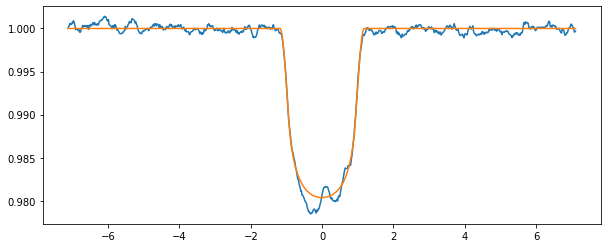

Theta max:  [3.72241883e-01 5.79127854e-01 1.74614676e-02 8.78364102e+01
 1.23514457e+00]


In [10]:
theta_max  = samples[numpy.argmax(sampler.flatlnprobability)]
print(theta_max)
best_fit_model = ajuste.eclipse_mcmc(time, theta_max)

plt.rcParams['figure.figsize']= 10, 4
graf1,ax = plt.subplots()
plt.plot(time, flux, label = 'flux')
plt.plot(time, best_fit_model, label='Highest Likelihood Model')
plt.show()
print('Theta max: ',theta_max)

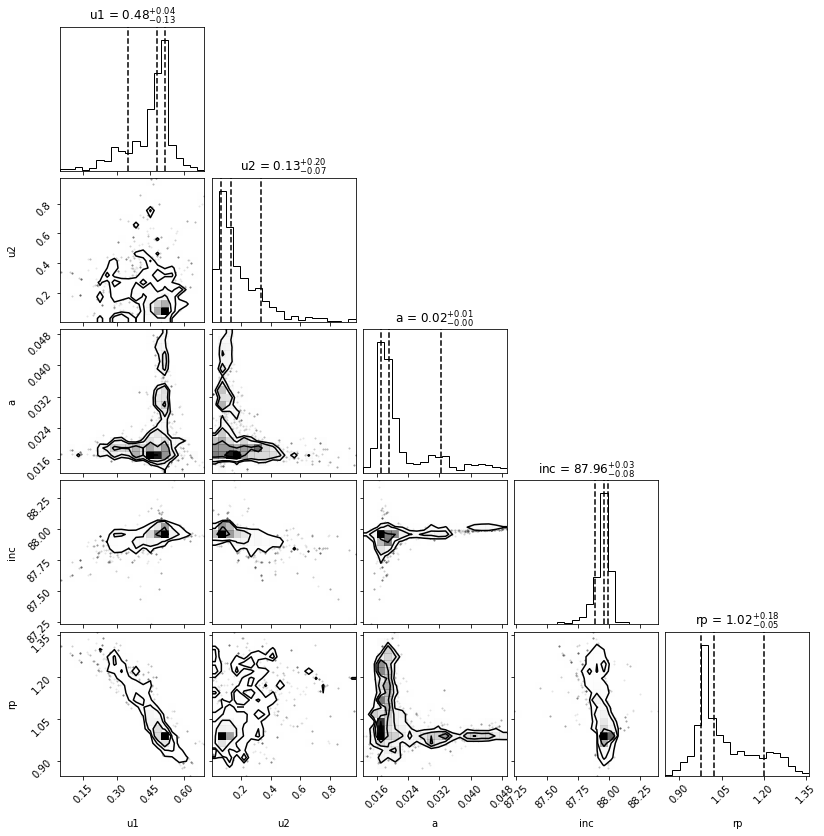

In [11]:
labels = ['u1','u2','a','inc','rp']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

# MCMC Manchado
_Ajustes realizados para a aplicação do algoritmo MCMC em uma Estrela manchada. Limita-se o número de manchas por estrelas a 4._

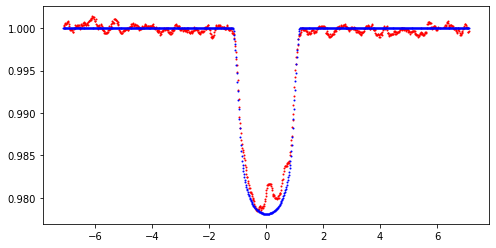

In [9]:
# Parâmetros resultados no primeiro mcmc (Sem manchas)
u1 = 3.72241883e-01
u2 = 5.79127854e-01
semiEixoUA = 1.74614676e-02
anguloInclinacao = 8.78364102e+01
raioPlanJup = 1.30514457e+00

rsun = 1.
periodo = 1.
raioStar, raioPlanetaRstar, semiEixoRaioStar = converte(rsun,raioPlanJup,semiEixoUA)

estrela_ = Estrela(373, raioStar, 240., u1, u2, 856)
Nx = estrela_.getNx()
Ny = estrela_.getNy()
raioEstrelaPixel = estrela_.getRaioStar()

estrelaManchada = estrela_.getEstrela()

eclipse = Eclipse(Nx,Ny,raioEstrelaPixel,estrelaManchada)
eclipse.setTempoHoras(1.)
eclipse.criarEclipse(semiEixoRaioStar, semiEixoUA, raioPlanetaRstar, raioPlanJup, periodo, anguloInclinacao, 0,0 , 0, False, False)

### Plotagem de resultados #### 
plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(time_phased, smoothed_LC, "r.", ms = 2)
ax.plot(ts_model, eclipse.getCurvaLuz(), "b.", ms = 2)

### Latitude das manchas 
Para que a mancha estejá alinhada à orbita do planeta, é necessária que a latitude desta esteja dentro da trajetória da órbita do planeta. Dessa forma, a seguir, sugerimos, com base no angulo de inclinação do planeta e seu semi-eixo, a latitude indicada para a plotagem das manchas. 

In [22]:
latsugerida = calculaLat(semiEixoRaioStar,anguloInclinacao)
print("A latitude sugerida para as estrelas é de:", latsugerida)

A latitude sugerida para as estrelas é de: -7.9939757246977425


In [10]:
nwalkers = 50
niter = 30
burnin = 10
ndim = 2
rsun = 1 #definir 
periodo = 1 #definir

ajusteManchado = AjusteManchado(tratamento, time_phased, smoothed_LC, nwalkers, niter, burnin, ndim, u1, u2, semiEixoUA, anguloInclinacao, raioPlanJup, rsun, periodo)

time = time_phased
flux = smoothed_LC

Running burn-in...


100%|██████████| 10/10 [06:56<00:00, 41.63s/it]


Running production...


100%|██████████| 30/30 [20:40<00:00, 41.34s/it]


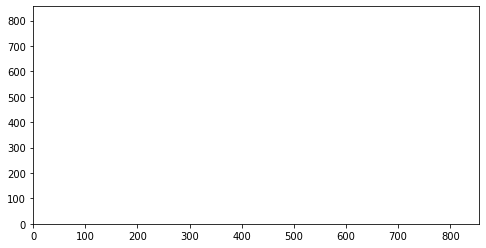

In [11]:
sampler, pos, prob, state = ajusteManchado.main()

In [12]:
samples = sampler.flatchain
samples[numpy.argmax(sampler.flatlnprobability)]

array([10.19275749, -9.90300008,  0.0579881 ,  0.24409397, 39.92189175,
       -9.94716613,  0.06074939,  0.09030236])

In [19]:
theta_max  = samples[numpy.argmax(sampler.flatlnprobability)]
print(theta_max)
best_fit_model = ajusteManchado.eclipse_mcmc(time, theta_max)

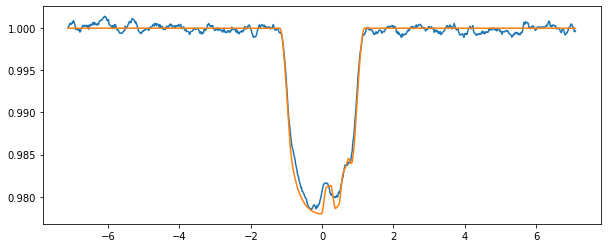

Theta max:  [10.19275749 -9.90300008  0.0579881   0.24409397 39.92189175 -9.94716613
  0.06074939  0.09030236]


In [17]:
### Plotagem de resultados #### 
plt.rcParams['figure.figsize']= 10, 4
graf1,ax = plt.subplots()
plt.plot(time, flux, label = 'flux')
plt.plot(time, best_fit_model, label='Highest Likelihood Model')
plt.show()
print('Theta max: ',theta_max)

# labels = ['latitude','longitude','raio','intensidade']
# fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])